# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Name & GitHub

- Name: Daniel Calderon
- GitHub Username: dhcalderon, A15633636

# Research Question

*Is the number repeat health inspections predominantly related to a region's income per capita as opposed to other factors?*

## Background and Prior Work

I work in the food industry, and the machinery at the restaurant I work at (things like dishwashers, grills, refrigerators, etc) is complicated to work with and difficult to maintain, not to mention all the single-use equipment that must be constantly replaced. A full expanded list of proper equipment maintenance is found in the first link, that being to North Carolina's health regulations (where the data is from), showcasing the full requirements that must go into proper upkeep. Meanwhile, The second link mentions that "general maintenance figures estimate it generally to be between 2 and 6 percent of a business’s overall budget", while also stating that improper budgeting for upkeep can lead to unsafe conditions. Therefore, having a lower income can easily lead to lower maintenance standards, and thus potential repeat inspections. My main question isn't so much whether or not this correlation exists, but rather if this is the primary relationship as opposed to other factors, like individual biases in the health inspectors or potential systemic rascism within health regulations.

References (include links):
- 1)https://ehs.ncpublichealth.com/faf/docs/foodprot/NC-FoodCodeManual-2009-FINAL.pdf
- 2)https://www.fsrmagazine.com/expert-takes/how-budget-restaurant-maintenance#:~:text=Typically%2C%20according%20to%20the%20National,of%20a%20business's%20overall%20budget.

# Hypothesis


*After some EDA, my hypothesis is that yes, the communities income, as show by the income per capita by zipcode, will be the dominant factor for repeat inspections, as the lower the per capita income, the lower the profits for a restaurant and the lower the revenue. I expect there to be some colinearity with a zipcode's percentage of non-white residents, as the poorest 2 poorest zipcodes were also majority non-white.*

# Dataset(s)

- Dataset Name: zipcodes.csv
- Number of observations: 39

zipcodes.csv shows the median amount of income per household and per family, as well as the per capita income for each area code. This dataset also includes percentages for poverty and benefits, as well as percentage of POC living in the postal code.

- Dataset Name: inspections.csv
- Number of observations: 18467

inspections.csv not only includes info about the restaurant name and location, but also details about the number of inspections, score, and inspector.

I plan on using inspections.csv by clustering the restaurants per zipcode, then gathering the average number of inspections and average code, then running multi linear regression with the variables in zipcodes.csv to find the interactions and predominant variable.

# Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="white", font_scale=2)

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (17, 7)

import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skewnorm

%config InlineBackend.figure_format ='retina'

In [2]:
#loading the datasets into pandas dataframes
i_df = pd.read_csv("inspections.csv")
z_df = pd.read_csv("zipcodes.csv")

# Data Cleaning

Describe your data cleaning steps here.

In [3]:
#I started by removing all non-restaurants from the inspections dataframe,
#since my research question pertains to restaurants and not other kinds of facilities

i_df = i_df.loc[i_df['facilitytype'] == 'Restaurant']

In [4]:
#Next, I sliced the columms I didn't need from the inspections.csv data frame. This also helps to annonymize the data.

i_df = i_df.loc[:, ['zip', 'inspection_num', 'score']]

In [5]:
#Once I had this, time to check and drop any rows with missing data

dropR = i_df[i_df.isnull().any(axis=1)]
dropR

,zip,inspection_num,score


In [6]:
#There's none, so we're good, time to group by zip!
i_df = i_df.groupby('zip').mean()

#Some visuals
i_df

,inspection_num,score
zip,,
27501,3.500000,94.750000
27502,4.118110,95.708661
27511,4.291579,96.194211
27512,3.500000,94.416667
27513,3.688805,94.936433
27518,4.492481,96.947368
27519,3.207729,95.891304
27520,3.769231,97.230769
27523,4.384615,95.358974


In [7]:
#Before I could make any merges though, I needed to make sure both dataframes had the same data types
i_df = i_df.reset_index()
i_df.dtypes, z_df.dtypes

(zip                 int64
 inspection_num    float64
 score             float64
 dtype: object, zip                                       int64
 median_family_income_dollars              int64
 median_household_income_dollars           int64
 per_capita_income_dollars                 int64
 percent_damilies_below_poverty_line     float64
 percent_snap_benefits                   float64
 percent_supplemental_security_income    float64
 percent_nonwhite                        float64
 dtype: object)

In [8]:
#Once I knew I had the same data types, I merged them into a single dataframe, df.
df = pd.merge(i_df, z_df, on='zip')
#Let's take a look at it
df

,zip,inspection_num,score,median_family_income_dollars,median_household_income_dollars,per_capita_income_dollars,percent_damilies_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite
0,27501,3.500000,94.750000,59408,51121,21631,10.5,15.5,5.2,17.9
1,27502,4.118110,95.708661,109891,95857,36763,3.4,2.4,0.8,18.9
2,27511,4.291579,96.194211,82292,67392,33139,9.6,4.5,2.2,24.8
3,27513,3.688805,94.936433,109736,87262,41232,3.8,2.4,1.5,27.8
4,27518,4.492481,96.947368,125432,98247,49865,5.5,1.0,1.7,19.9
5,27519,3.207729,95.891304,137193,121815,45778,3.2,2.3,2.3,35.2
6,27520,3.769231,97.230769,67939,58455,25628,5.0,7.8,2.4,23.5
7,27523,4.384615,95.358974,89184,68342,36976,3.1,3.1,1.8,22.4
8,27526,4.364035,94.007675,74666,66025,28074,8.4,8.3,3.9,22.5
9,27529,3.455840,96.344729,68627,59613,25807,9.5,7.6,4.8,33.9


In [9]:
#Some of these column names were a mouthful, I renaming was in order
df = df.rename(columns={'median_family_income_dollars': 'family', 
                        'median_household_income_dollars': 'household', 
                        'per_capita_income_dollars': 'per_capita', 
                        'percent_damilies_below_poverty_line': 'poverty', 
                        'percent_snap_benefits': 'snap', 
                        'percent_supplemental_security_income': 'supplement', 
                        'percent_nonwhite': 'POC'})
df

,zip,inspection_num,score,family,household,per_capita,poverty,snap,supplement,POC
0,27501,3.500000,94.750000,59408,51121,21631,10.5,15.5,5.2,17.9
1,27502,4.118110,95.708661,109891,95857,36763,3.4,2.4,0.8,18.9
2,27511,4.291579,96.194211,82292,67392,33139,9.6,4.5,2.2,24.8
3,27513,3.688805,94.936433,109736,87262,41232,3.8,2.4,1.5,27.8
4,27518,4.492481,96.947368,125432,98247,49865,5.5,1.0,1.7,19.9
5,27519,3.207729,95.891304,137193,121815,45778,3.2,2.3,2.3,35.2
6,27520,3.769231,97.230769,67939,58455,25628,5.0,7.8,2.4,23.5
7,27523,4.384615,95.358974,89184,68342,36976,3.1,3.1,1.8,22.4
8,27526,4.364035,94.007675,74666,66025,28074,8.4,8.3,3.9,22.5
9,27529,3.455840,96.344729,68627,59613,25807,9.5,7.6,4.8,33.9


# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [10]:
#Now that we have our dataframe, let's go ahead and run the analysis, 
#starting by looking at the effect of per capita income on inspections
outcome, predictors = patsy.dmatrices('inspection_num ~ per_capita', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         inspection_num   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.5787
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.452
Time:                        23:49:08   Log-Likelihood:                -14.000
No. Observations:                  35   AIC:                             32.00
Df Residuals:                      33   BIC:                             35.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1617      0.221     18.816      0.0

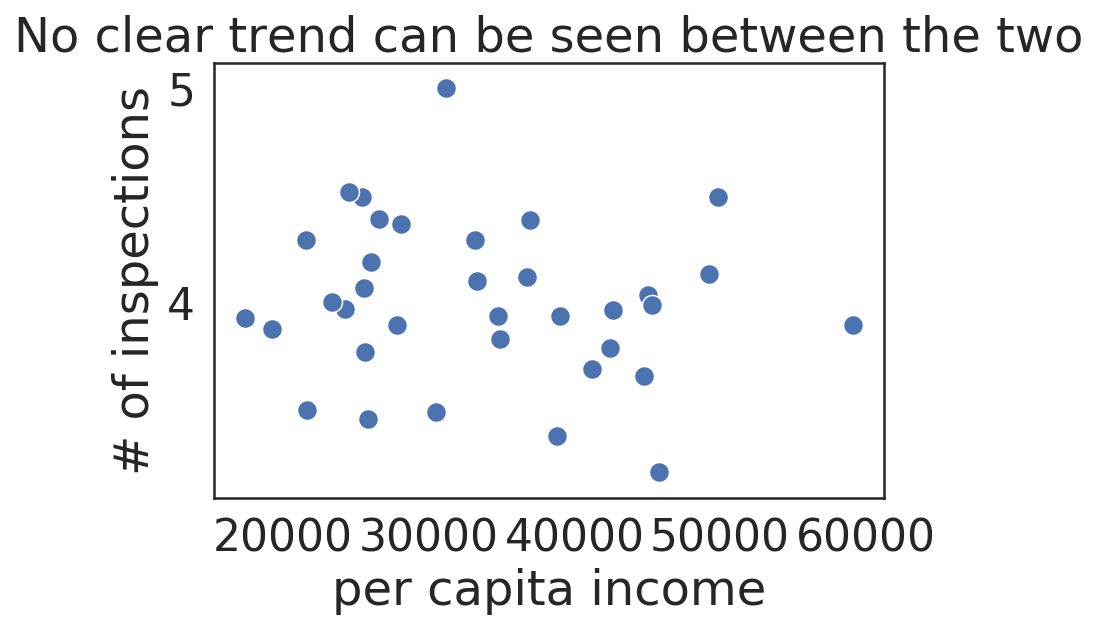

In [11]:
#Some visuals of the two.
plot = sns.scatterplot(x='per_capita', y='inspection_num', data=df, s=100)
plt.xlabel('per capita income')
plt.ylabel('# of inspections')
plot.set_title('No clear trend can be seen between the two');

Immediately we can see that my hypothesis needs to be rejected. Considering how large the p-value is, and how no clear trend in visible in the plot, per capita income does not correlate to repeat inspections

After this I decided to try the other variables to see if I could found some correlation. I did find something interesting with the supplementary income...

In [12]:
outcome, predictors = patsy.dmatrices('inspection_num ~ supplement', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         inspection_num   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.994
Date:                Wed, 10 Jun 2020   Prob (F-statistic):             0.0540
Time:                        23:49:08   Log-Likelihood:                -12.304
No. Observations:                  35   AIC:                             28.61
Df Residuals:                      33   BIC:                             31.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8621      0.091     42.209      0.0

Let's view the graph!

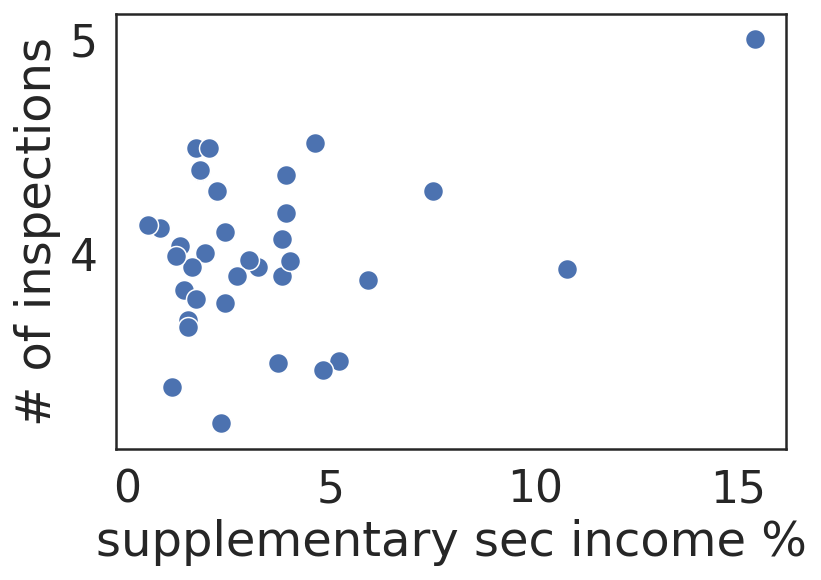

In [13]:
plot = sns.scatterplot(x='supplement', y='inspection_num', data=df, s=100)
plt.xlabel('supplementary sec income %')
plt.ylabel('# of inspections');

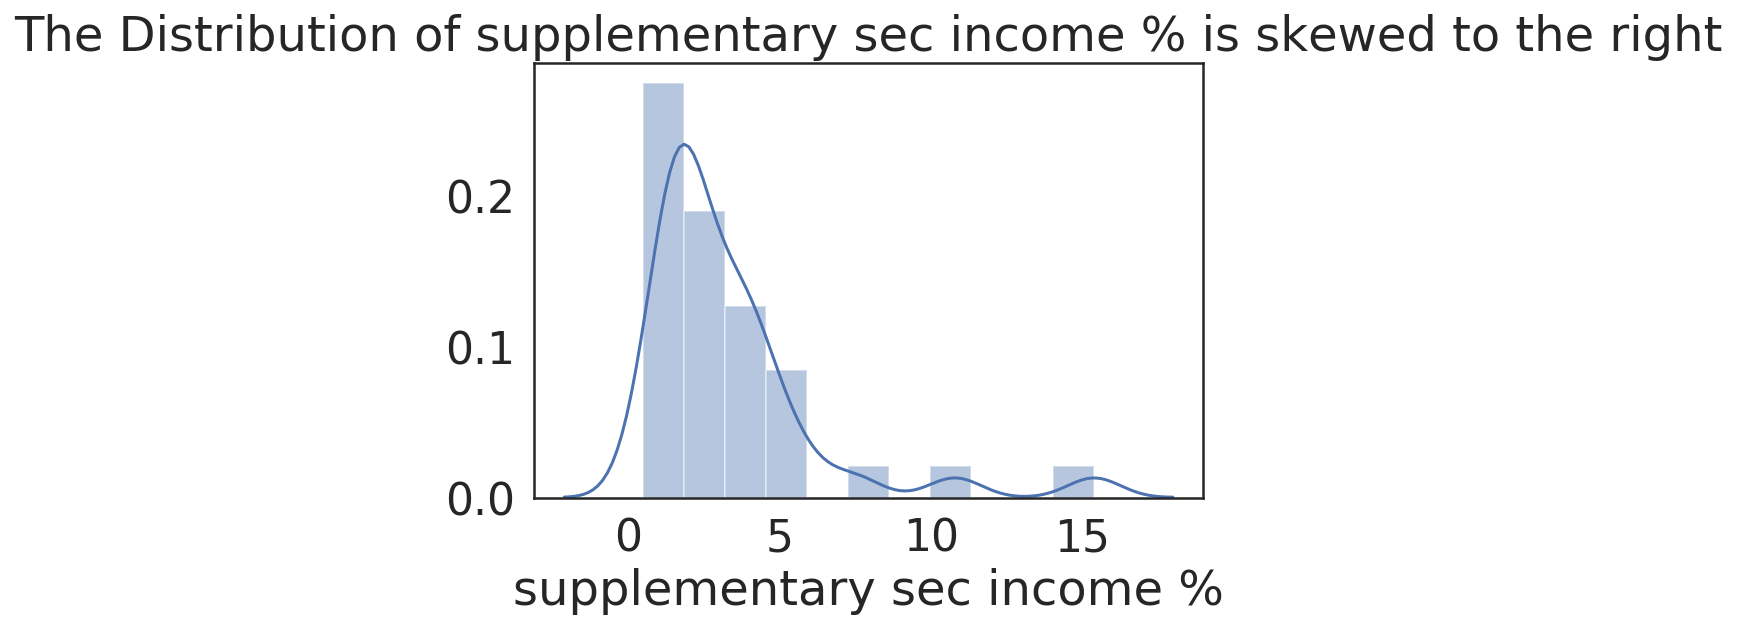

In [14]:
plit = sns.distplot(df['supplement'][df['supplement'].notnull()],hist=True)
plt.xlabel('supplementary sec income %')
plit.set_title('The Distribution of supplementary sec income % is skewed to the right');

In [15]:
#Let's fix that up with a log transformation:
df['supplementLog'] = np.log10(df['supplement'])

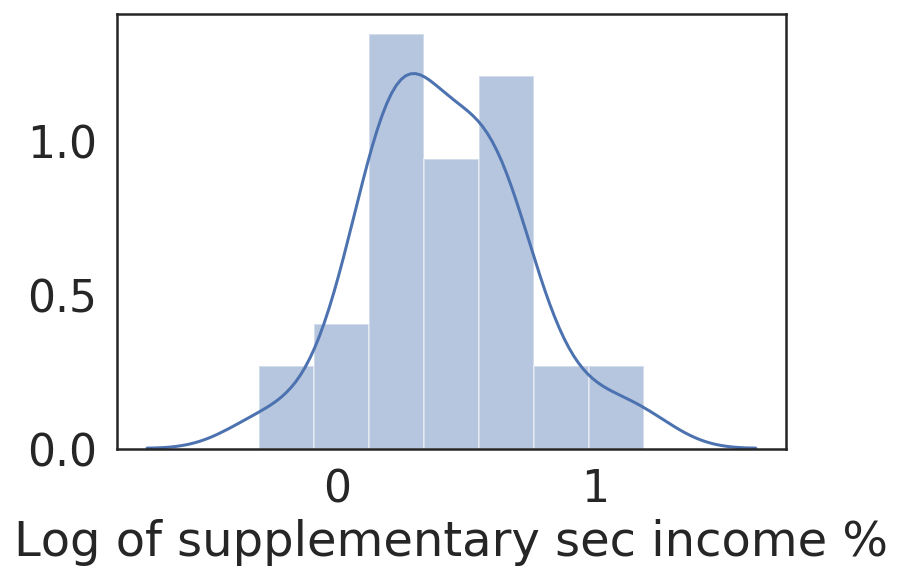

In [16]:
sns.distplot(df['supplementLog'][df['supplementLog'].notnull()],hist=True)
plt.xlabel('Log of supplementary sec income %');

With this more normal distribution, I decided to make another scatterplot with the log of supplementary sec income and # of inspections.

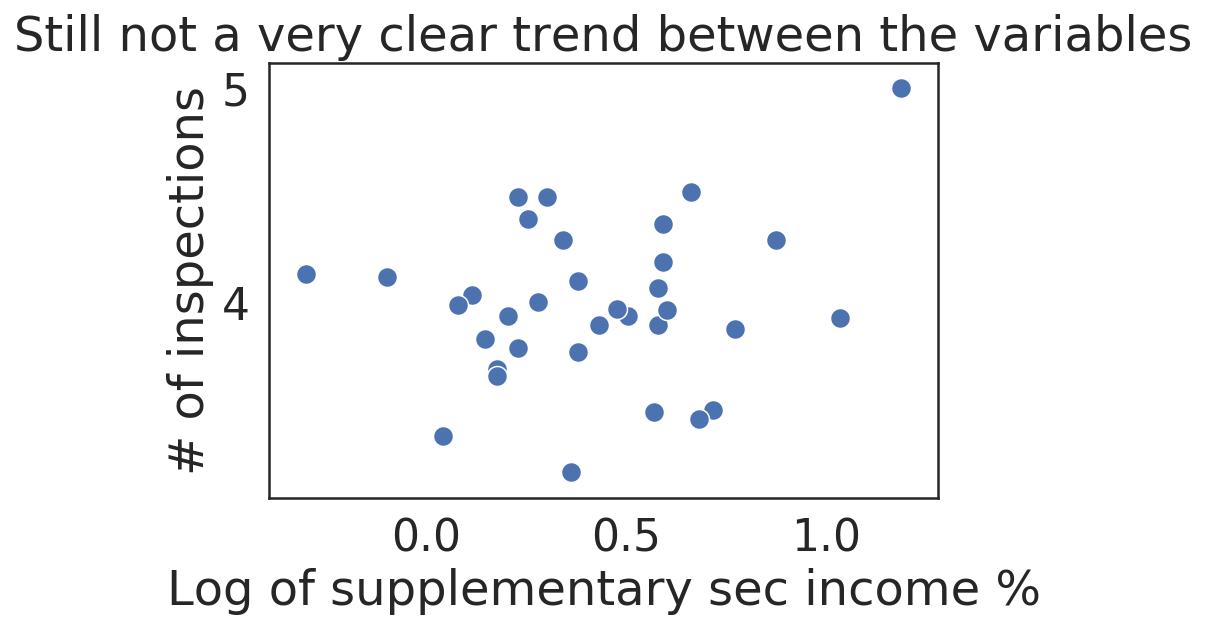

In [17]:
plet = sns.scatterplot(x='supplementLog', y='inspection_num', data=df, s=100)
plt.xlabel('Log of supplementary sec income %')
plt.ylabel('# of inspections')
plet.set_title('Still not a very clear trend between the variables');

Let's run the analysis:

Alas, still not a clear trend correlation. Let's combine it with another variable, poverty %.

In [18]:
utcome, predictors = patsy.dmatrices('inspection_num ~ supplement + poverty', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         inspection_num   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     2.142
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.134
Time:                        23:49:11   Log-Likelihood:                -12.105
No. Observations:                  35   AIC:                             30.21
Df Residuals:                      32   BIC:                             34.88
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8898      0.103     37.746      0.0

Let's view the relationship between poverty % and # of inspections:

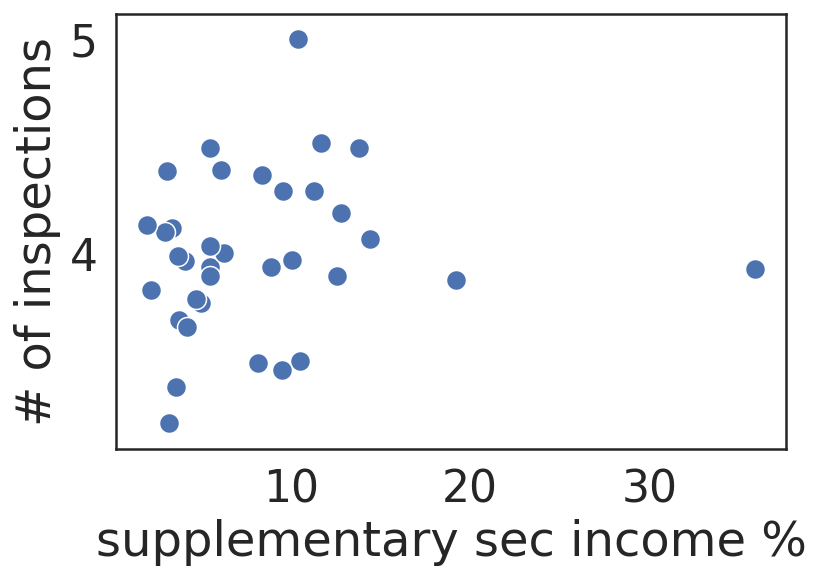

In [19]:
plot = sns.scatterplot(x='poverty', y='inspection_num', data=df, s=100)
plt.xlabel('poverty %')
plt.ylabel('# of inspections');

Note the two outliers in the right, let's get rid of them

In [20]:
cut = df[df['poverty'] < 19]

In [23]:
#Analysis again...
outcome, predictors = patsy.dmatrices('inspection_num ~ supplement + poverty', cut)
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         inspection_num   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     3.232
Date:                Wed, 10 Jun 2020   Prob (F-statistic):             0.0536
Time:                        23:50:06   Log-Likelihood:                -11.162
No. Observations:                  33   AIC:                             28.32
Df Residuals:                      30   BIC:                             32.81
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7567      0.136     27.604      0.0

And there's still no clear correlation. As a result, I failed to reject the null, and must admit that none of these variables have a significant enough role in predicting the number of repeat inspections

# Ethics & Privacy

*My main worry regarding privacy is in the geographic subdivision of zipcodes. Given how the data is not about individuals, and the analysis isn't about individual restaurants, I'm fairly certain that this isn't a violation of the Safe Harbour Method (as these guidelines specifically state individuals).*

# Conclusion & Discussion

After cleaning the data and running analyses, I've come to the conclusion that none of the variables listed in zipcodes.csv are accurate predictors for the number of repeat inspections. Therefore, we cannot predict how many repeat inspections a restaurant will have based on their zip code, or which community they belong to. To be fair, quite a lot of entries were removed from inspections.csv, so there's a chance that while a zip code does not correlate with a restaurant's number of inspections, it might correlate with other types of food facilities.